## This cell loads libraries, sets global configuration and experiment parameters.

In [3]:
import os
import warnings
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
    balanced_accuracy_score,
    matthews_corrcoef,
    confusion_matrix,
)
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

CSV_PATH = "/kaggle/input/aci-iot-network-traffic-dataset-2023/ACI-IoT-2023-Payload.csv"
LABEL_COLUMN = "label"
BENIGN_LABEL_NAME = "Benign"

EXPERIMENT_CONFIG = {
    "sample_frac": 0.2,           # increase later if time allows
    "val_size": 0.2,              # fraction of temp set
    "test_size": 0.2,             # fraction of full set
    "max_dbscan_samples": 40_000,
    "dbscan_eps": 1.5,
    "dbscan_min_samples": 20,
    "pca_components_dbscan": 3,
    "ae_epochs": 20,
    "ae_batch_size": 512,
    "common_ports": [80, 443, 53, 22, 1883],
}

# Optional: force CPU for TensorFlow (reduces noisy CUDA init logs)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

KERAS_AVAILABLE = False
try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.optimizers import Adam
    KERAS_AVAILABLE = True
    print("[INFO] TensorFlow/Keras detected. Autoencoder will be available.")
except Exception as e:
    print("[INFO] TensorFlow/Keras NOT available. Autoencoder will be skipped.")
    KERAS_AVAILABLE = False

print("Imports & configuration ready.")


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

[INFO] TensorFlow/Keras detected. Autoencoder will be available.
Imports & configuration ready.


## Loads the dataset and optionally samples it for faster experimentation.

In [4]:
def load_aci_iot(csv_path: str, sample_frac: float = 1.0, random_state: int = RANDOM_SEED) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Path not found: {csv_path}")

    print(f"[INFO] Loading dataset from: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"[INFO] Original shape: {df.shape}")

    if 0 < sample_frac < 1.0:
        df = df.sample(frac=sample_frac, random_state=random_state).reset_index(drop=True)
        print(f"[INFO] After downsampling (frac={sample_frac}): {df.shape}")

    return df

df = load_aci_iot(CSV_PATH, sample_frac=EXPERIMENT_CONFIG["sample_frac"])
print("\n[INFO] First 5 rows:")
display(df.head())


[INFO] Loading dataset from: /kaggle/input/aci-iot-network-traffic-dataset-2023/ACI-IoT-2023-Payload.csv
[INFO] Original shape: (631486, 10)
[INFO] After downsampling (frac=0.2): (126297, 10)

[INFO] First 5 rows:


,srcip,sport,dstip,dsport,protocol_m,sttl,total_len,payload,stime,label
0,13.35.90.199,443,192.168.1.207,48508,tcp,243,12364,bcf2c381a95b0de4b8ce1c8c5b436d3d9f425445d22ebb...,1699019690,Benign
1,91.189.91.43,443,192.168.2.3,60026,tcp,48,1420,1703033fd1b073dd6586f35129b358fbe5ccafeb803245...,1698770769,Benign
2,13.35.90.143,443,192.168.1.207,57286,tcp,243,2788,28be5ff964a5a9c3527ade016d2cd2696adaaa9aecb827...,1699024501,Benign
3,13.35.90.199,443,192.168.1.207,48814,tcp,243,4156,a2811d4001a817e0b1fe2d359f08cc9a41f093c69ffdb6...,1699023176,Benign
4,13.35.90.143,443,192.168.1.207,57286,tcp,243,5524,9912f28fe5604a5da825f6f8e21788b78faf09b80329ac...,1699026989,Benign


## Creates binary_label (Benign=0, Attack=1) for evaluation and builds engineered features.
## Drops raw identifiers + raw payload content (but uses payload length).

In [5]:
def create_binary_labels(df: pd.DataFrame,
                         label_col: str = LABEL_COLUMN,
                         benign_label: str = BENIGN_LABEL_NAME) -> pd.DataFrame:
    if label_col not in df.columns:
        raise ValueError(f"Label column '{label_col}' not found.")

    df = df.copy()
    df[label_col] = df[label_col].astype(str)
    df["binary_label"] = (df[label_col] != benign_label).astype(int)

    print("\n[INFO] Original label distribution:")
    print(df[label_col].value_counts())
    print("\n[INFO] Binary label distribution (0=normal, 1=attack):")
    print(df["binary_label"].value_counts())

    return df


def build_feature_dataframe_full(df_raw: pd.DataFrame) -> tuple[pd.DataFrame, np.ndarray, list]:
    """
    Final engineered feature set (tabular + interpretable):
      - ports, ttl, traffic size
      - log traffic size
      - payload length (hex -> bytes)
      - common destination port indicator
      - hour of day
      - protocol one-hot

    Drops:
      - srcip/dstip (identifiers)
      - payload (raw high-dimensional)
    """
    df = df_raw.copy()

    # --- Payload length: hex string -> bytes (more realistic than string length) ---
    if "payload" in df.columns:
        payload_str = df["payload"].fillna("").astype(str)
        df["payload_len"] = (payload_str.str.len() // 2).astype(int)
    else:
        df["payload_len"] = 0

    # Numeric conversions
    for col in ["sport", "dsport", "sttl", "total_len", "stime"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Fix missing values lightly (more robust scaling later)
    df["total_len"] = df["total_len"].fillna(0)
    df["sport"] = df["sport"].fillna(0)
    df["dsport"] = df["dsport"].fillna(0)
    df["sttl"] = df["sttl"].fillna(0)

    # Log transform of total_len (handle skew)
    df["log_total_len"] = np.log1p(df["total_len"])

    # Common destination ports flag
    df["is_common_dport"] = df["dsport"].isin(EXPERIMENT_CONFIG["common_ports"]).astype(int)

    # Hour-of-day from UNIX timestamp
    dt = pd.to_datetime(df["stime"], unit="s", errors="coerce")
    df["hour_of_day"] = dt.dt.hour.fillna(0).astype(int)

    # Drop identifier & raw payload
    drop_cols = [c for c in ["srcip", "dstip", "payload"] if c in df.columns]
    if drop_cols:
        print(f"\n[INFO] Dropping ID/raw columns: {drop_cols}")
        df = df.drop(columns=drop_cols)

    # One-hot protocol
    if "protocol_m" not in df.columns:
        raise ValueError("Expected 'protocol_m' in dataset.")
    df = pd.get_dummies(df, columns=["protocol_m"], drop_first=True)

    # Convert protocol dummy booleans to int for clarity
    for c in df.columns:
        if c.startswith("protocol_m_"):
            df[c] = df[c].astype(int)

    # Feature list
    numeric_cols = [
        "sport", "dsport", "sttl", "total_len",
        "log_total_len", "payload_len",
        "is_common_dport", "hour_of_day"
    ]
    protocol_cols = [c for c in df.columns if c.startswith("protocol_m_")]
    feature_cols = numeric_cols + protocol_cols

    X_features = df[feature_cols].copy()
    y = df["binary_label"].values

    print("\n[INFO] Feature columns used:")
    print(feature_cols)
    print("[INFO] Feature matrix shape:", X_features.shape)

    return X_features, y, feature_cols


df = create_binary_labels(df, label_col=LABEL_COLUMN, benign_label=BENIGN_LABEL_NAME)
X_all_features, y_all, feature_cols = build_feature_dataframe_full(df)

print("\n[INFO] Sample engineered features:")
display(X_all_features.head())



[INFO] Original label distribution:
label
Benign                120406
DNS Flood               3689
Dictionary Attack        942
Slowloris                559
SYN Flood                422
Port Scan                127
Vulnerability Scan        92
OS Scan                   31
ICMP Flood                15
UDP Flood                 14
Name: count, dtype: int64

[INFO] Binary label distribution (0=normal, 1=attack):
binary_label
0    120406
1      5891
Name: count, dtype: int64

[INFO] Dropping ID/raw columns: ['srcip', 'dstip', 'payload']

[INFO] Feature columns used:
['sport', 'dsport', 'sttl', 'total_len', 'log_total_len', 'payload_len', 'is_common_dport', 'hour_of_day', 'protocol_m_tcp', 'protocol_m_udp']
[INFO] Feature matrix shape: (126297, 10)

[INFO] Sample engineered features:


,sport,dsport,sttl,total_len,log_total_len,payload_len,is_common_dport,hour_of_day,protocol_m_tcp,protocol_m_udp
0,443,48508,243,12364,9.422625,12312,0,13,1,0
1,443,60026,48,1420,7.259116,1368,0,16,1,0
2,443,57286,243,2788,7.933438,2736,0,15,1,0
3,443,48814,243,4156,8.332549,4104,0,14,1,0
4,443,57286,243,5524,8.617039,5472,0,15,1,0


## Splits data (stratified), cleans numeric issues, and scales features.
## Scaler is fit on TRAIN only to prevent leakage.


In [6]:
def summarize_split(name, y):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n--- {name} Split ---")
    print("Total samples:", len(y))
    print("Label counts (0=normal,1=attack):", dict(zip(unique, counts)))


def clean_features(df_features: pd.DataFrame) -> pd.DataFrame:
    df = df_features.apply(pd.to_numeric, errors="coerce")
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    return df


def scale_features(train_df, val_df, test_df, feature_cols):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_df[feature_cols].values)
    X_val_scaled = scaler.transform(val_df[feature_cols].values)
    X_test_scaled = scaler.transform(test_df[feature_cols].values)
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler


# Split
X_temp, X_test_df, y_temp, y_test = train_test_split(
    X_all_features, y_all,
    test_size=EXPERIMENT_CONFIG["test_size"],
    stratify=y_all,
    random_state=RANDOM_SEED
)
X_train_df, X_val_df, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=EXPERIMENT_CONFIG["val_size"],
    stratify=y_temp,
    random_state=RANDOM_SEED
)

summarize_split("Train", y_train)
summarize_split("Validation", y_val)
summarize_split("Test", y_test)

# Clean
X_train_df = clean_features(X_train_df)
X_val_df = clean_features(X_val_df)
X_test_df = clean_features(X_test_df)

# Scale
X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_features(
    X_train_df, X_val_df, X_test_df, feature_cols
)

print("\n[INFO] Shapes after scaling:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_val_scaled  :", X_val_scaled.shape)
print("X_test_scaled :", X_test_scaled.shape)



--- Train Split ---
Total samples: 80829
Label counts (0=normal,1=attack): {0: 77059, 1: 3770}

--- Validation Split ---
Total samples: 20208
Label counts (0=normal,1=attack): {0: 19265, 1: 943}

--- Test Split ---
Total samples: 25260
Label counts (0=normal,1=attack): {0: 24082, 1: 1178}

[INFO] Shapes after scaling:
X_train_scaled: (80829, 10)
X_val_scaled  : (20208, 10)
X_test_scaled : (25260, 10)


## Reusable helpers: metrics, confusion matrix printing, PR curve plotting, threshold tuning.

In [7]:
def evaluate_model(y_true, y_pred, scores, model_name: str) -> dict:
    metrics = {
        "model": model_name,
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "mcc": matthews_corrcoef(y_true, y_pred),
    }

    if scores is not None:
        try:
            metrics["roc_auc"] = roc_auc_score(y_true, scores)
        except ValueError:
            metrics["roc_auc"] = np.nan

        prec, rec, _ = precision_recall_curve(y_true, scores)
        metrics["pr_auc"] = auc(rec, prec)
    else:
        metrics["roc_auc"] = np.nan
        metrics["pr_auc"] = np.nan

    return metrics


def print_confusion_details(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print("\nConfusion Matrix:")
    print(f"TN (correct normals) : {tn}")
    print(f"FP (false alarms)    : {fp}")
    print(f"FN (missed attacks)  : {fn}")
    print(f"TP (detected attacks): {tp}")


def print_metrics(metrics: dict):
    print(f"\n=== {metrics['model']} ===")
    print(f"Accuracy          : {metrics['accuracy']:.4f}")
    print(f"Balanced Accuracy : {metrics['balanced_accuracy']:.4f}")
    print(f"Precision         : {metrics['precision']:.4f}")
    print(f"Recall            : {metrics['recall']:.4f}")
    print(f"F1-score          : {metrics['f1']:.4f}")
    print(f"MCC               : {metrics['mcc']:.4f}")
    print("ROC-AUC           : ", "N/A" if np.isnan(metrics['roc_auc']) else f"{metrics['roc_auc']:.4f}")
    print("PR-AUC            : ", "N/A" if np.isnan(metrics['pr_auc']) else f"{metrics['pr_auc']:.4f}")


def plot_precision_recall(scores_dict: dict, y_true, title_suffix=""):
    plt.figure(figsize=(8, 5))
    for model_name, scores in scores_dict.items():
        prec, rec, _ = precision_recall_curve(y_true, scores)
        pr_auc_val = auc(rec, prec)
        plt.plot(rec, prec, label=f"{model_name} (PR-AUC={pr_auc_val:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curves {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def tune_threshold_max_f1(y_val, val_scores):
    """
    Tune threshold on validation scores by maximizing F1.
    Important: use precision[:-1] / recall[:-1] to align with thresholds.
    """
    prec, rec, thresh = precision_recall_curve(y_val, val_scores)
    f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    best_idx = int(np.argmax(f1s))
    best_thr = float(thresh[best_idx])
    best_f1 = float(f1s[best_idx])
    return best_thr, best_f1

print("Evaluation helpers ready.")


Evaluation helpers ready.


## Isolation Forest learns “normal” from benign training samples.
## We tune the decision threshold on validation by max F1, then evaluate on test.

[IF] Training on benign-only train subset: 77059 samples
[IF] Best validation F1=0.2811 at threshold=-0.090641

=== IsolationForest (benign-only, tuned) ===
Accuracy          : 0.7850
Balanced Accuracy : 0.8513
Precision         : 0.1693
Recall            : 0.9244
F1-score          : 0.2862
MCC               : 0.3400
ROC-AUC           :  0.8537
PR-AUC            :  0.1366

Confusion Matrix:
TN (correct normals) : 18739
FP (false alarms)    : 5343
FN (missed attacks)  : 89
TP (detected attacks): 1089


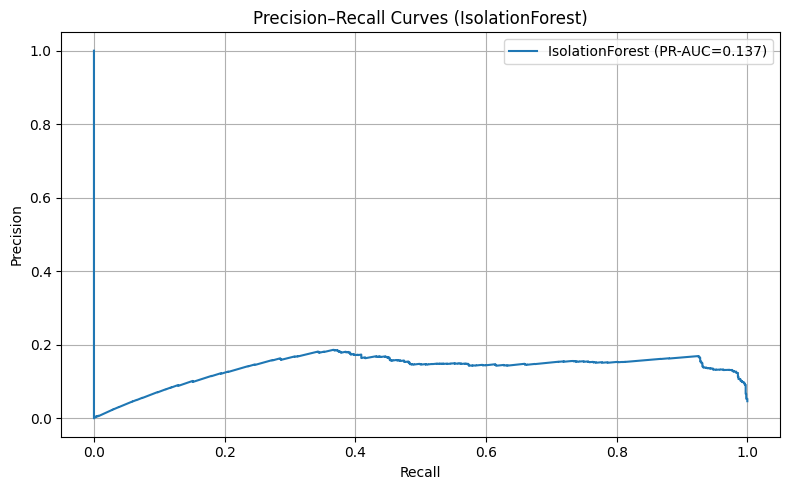

In [11]:
X_train_benign = X_train_scaled[y_train == 0]
print(f"[IF] Training on benign-only train subset: {X_train_benign.shape[0]} samples")

iso = IsolationForest(
    contamination=(0.01),
    random_state=RANDOM_SEED,
    n_jobs=-1
)

iso.fit(X_train_benign)

val_scores_if = -iso.decision_function(X_val_scaled)
test_scores_if = -iso.decision_function(X_test_scaled)

best_thresh_if, best_f1_if = tune_threshold_max_f1(y_val, val_scores_if)
print(f"[IF] Best validation F1={best_f1_if:.4f} at threshold={best_thresh_if:.6f}")

y_test_pred_if = (test_scores_if >= best_thresh_if).astype(int)
metrics_if = evaluate_model(y_test, y_test_pred_if, test_scores_if, "IsolationForest (benign-only, tuned)")
print_metrics(metrics_if)
print_confusion_details(y_test, y_test_pred_if)
plot_precision_recall({"IsolationForest": test_scores_if}, y_test, title_suffix="(IsolationForest)")


## LOF detects anomalies as points with lower local density than neighbors.
## We fit on benign-only and score validation/test flows.

[LOF] Training on benign-only train subset: 77059 samples
[LOF] Best validation F1=0.2444 at threshold=1.004757

=== LOF (benign-only, tuned) ===
Accuracy          : 0.7409
Balanced Accuracy : 0.7910
Precision         : 0.1354
Recall            : 0.8463
F1-score          : 0.2335
MCC               : 0.2701
ROC-AUC           :  0.7164
PR-AUC            :  0.0939

Confusion Matrix:
TN (correct normals) : 17717
FP (false alarms)    : 6365
FN (missed attacks)  : 181
TP (detected attacks): 997


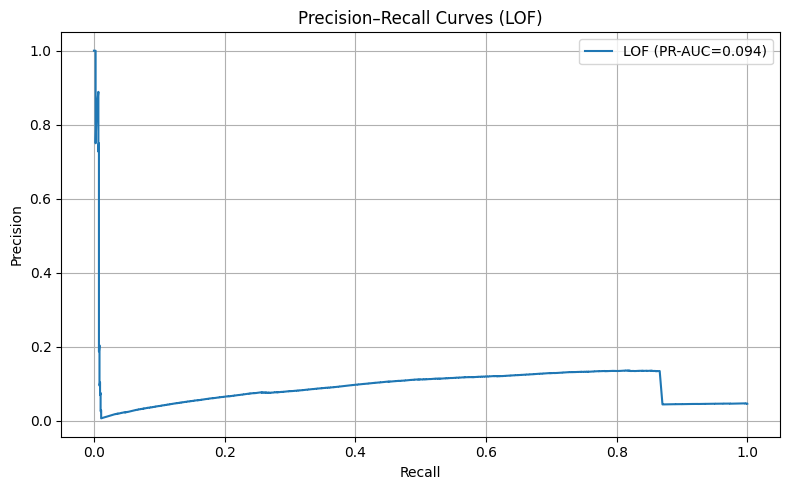

In [10]:
print(f"[LOF] Training on benign-only train subset: {X_train_benign.shape[0]} samples")

lof = LocalOutlierFactor(
    n_neighbors=20,
    novelty=True,
    n_jobs=-1
)
lof.fit(X_train_benign)

val_scores_lof = -lof.score_samples(X_val_scaled)
test_scores_lof = -lof.score_samples(X_test_scaled)

best_thresh_lof, best_f1_lof = tune_threshold_max_f1(y_val, val_scores_lof)
print(f"[LOF] Best validation F1={best_f1_lof:.4f} at threshold={best_thresh_lof:.6f}")

y_test_pred_lof = (test_scores_lof >= best_thresh_lof).astype(int)
metrics_lof = evaluate_model(y_test, y_test_pred_lof, test_scores_lof, "LOF (benign-only, tuned)")
print_metrics(metrics_lof)
print_confusion_details(y_test, y_test_pred_lof)
plot_precision_recall({"LOF": test_scores_lof}, y_test, title_suffix="(LOF)")


## Autoencoder reconstructs normal traffic with low error.
## High reconstruction error indicates anomaly.

In [21]:
metrics_ae = None

if not KERAS_AVAILABLE:
    print("[AE] TensorFlow/Keras not available; skipping Autoencoder.")
else:
    print("[AE] Training Autoencoder on benign-only train subset.")

    input_dim = X_train_scaled.shape[1]
    ae_epochs = EXPERIMENT_CONFIG["ae_epochs"]
    ae_batch_size = EXPERIMENT_CONFIG["ae_batch_size"]

    inp = Input(shape=(input_dim,))
    x = Dense(16, activation="relu")(inp)
    x = Dense(8, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    out = Dense(input_dim, activation="linear")(x)

    autoencoder = Model(inputs=inp, outputs=out)
    autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")

    autoencoder.fit(
        X_train_benign, X_train_benign,
        epochs=ae_epochs,
        batch_size=ae_batch_size,
        shuffle=True,
        verbose=0
    )

    # Scores = reconstruction error
    val_recon = autoencoder.predict(X_val_scaled, verbose=0)
    val_mse = np.mean((X_val_scaled - val_recon) ** 2, axis=1)

    test_recon = autoencoder.predict(X_test_scaled, verbose=0)
    test_mse = np.mean((X_test_scaled - test_recon) ** 2, axis=1)

    best_thresh_ae, best_f1_ae = tune_threshold_max_f1(y_val, val_mse)
    print(f"[AE] Best validation F1={best_f1_ae:.4f} at threshold={best_thresh_ae:.6f}")

    y_test_pred_ae = (test_mse >= best_thresh_ae).astype(int)
    metrics_ae = evaluate_model(y_test, y_test_pred_ae, test_mse, "Autoencoder (benign-only, tuned)")
    print_metrics(metrics_ae)
    print_confusion_details(y_test, y_test_pred_ae)
    plot_precision_recall({"Autoencoder": test_mse}, y_test, title_suffix="(Autoencoder)")


[AE] TensorFlow/Keras not available; skipping Autoencoder.


## DBSCAN

In [22]:
n_db = min(EXPERIMENT_CONFIG["max_dbscan_samples"], X_test_scaled.shape[0])

rng = np.random.default_rng(RANDOM_SEED)
db_idx = rng.choice(len(X_test_scaled), size=n_db, replace=False)

X_db = X_test_scaled[db_idx]
y_db_true = y_test[db_idx]

print("[DBSCAN] Fitting PCA on benign-only training data...")

pca = PCA(
    n_components=EXPERIMENT_CONFIG["pca_components_dbscan"],
    random_state=RANDOM_SEED
)

X_train_benign = X_train_scaled[y_train == 0]
X_train_benign_pca = pca.fit_transform(X_train_benign)

print("[DBSCAN] Fitting DBSCAN on benign-only training data...")

dbscan = DBSCAN(
    eps=EXPERIMENT_CONFIG["dbscan_eps"],
    min_samples=EXPERIMENT_CONFIG["dbscan_min_samples"],
    n_jobs=-1
)

dbscan.fit(X_train_benign_pca)

from sklearn.neighbors import NearestNeighbors

print("[DBSCAN] Classifying test samples by distance to DBSCAN core points...")

core_samples = dbscan.components_

nn = NearestNeighbors(n_neighbors=1)
nn.fit(core_samples)

X_db_pca = pca.transform(X_db)

distances, _ = nn.kneighbors(X_db_pca)

y_pred_db = (distances[:, 0] > EXPERIMENT_CONFIG["dbscan_eps"]).astype(int)

metrics_db = evaluate_model(y_db_true, y_pred_db, None, "DBSCAN+PCA (inductive baseline)")
print_metrics(metrics_db)
print_confusion_details(y_db_true, y_pred_db)


[DBSCAN] Fitting PCA on benign-only training data...
[DBSCAN] Fitting DBSCAN on benign-only training data...
[DBSCAN] Classifying test samples by distance to DBSCAN core points...

=== DBSCAN+PCA (inductive baseline) ===
Accuracy          : 0.9533
Balanced Accuracy : 0.5000
Precision         : 0.0000
Recall            : 0.0000
F1-score          : 0.0000
MCC               : -0.0014
ROC-AUC           :  N/A
PR-AUC            :  N/A

Confusion Matrix:
TN (correct normals) : 24081
FP (false alarms)    : 1
FN (missed attacks)  : 1178
TP (detected attacks): 0


In [12]:
# --- DBSCAN + PCA (exploratory baseline, leakage-safe, unbiased sampling) ---

n_db = min(EXPERIMENT_CONFIG["max_dbscan_samples"], X_test_scaled.shape[0])

rng = np.random.default_rng(RANDOM_SEED)
db_idx = rng.choice(len(X_test_scaled), size=n_db, replace=False)

X_db = X_test_scaled[db_idx]
y_db_true = y_test[db_idx]

print("[DBSCAN] Fitting PCA on benign-only training data...")
pca = PCA(n_components=EXPERIMENT_CONFIG["pca_components_dbscan"], random_state=RANDOM_SEED)
pca.fit(X_train_scaled[y_train == 0])

X_db_pca = pca.transform(X_db)
print(f"[DBSCAN] PCA-transformed test shape: {X_db_pca.shape}")

print(f"[DBSCAN] Running DBSCAN on {n_db} TEST samples...")
dbscan = DBSCAN(
    eps=EXPERIMENT_CONFIG["dbscan_eps"],
    min_samples=EXPERIMENT_CONFIG["dbscan_min_samples"],
    n_jobs=-1
)
labels_db = dbscan.fit_predict(X_db_pca)
y_pred_db = (labels_db == -1).astype(int)

metrics_db = evaluate_model(y_db_true, y_pred_db, None, "DBSCAN+PCA (exploratory baseline)")
print_metrics(metrics_db)
print_confusion_details(y_db_true, y_pred_db)

unique_labels, counts = np.unique(labels_db, return_counts=True)
print("\n[DBSCAN] Cluster distribution (including noise = -1):")
print(dict(zip(unique_labels, counts)))


[DBSCAN] Fitting PCA on benign-only training data...
[DBSCAN] PCA-transformed test shape: (25260, 3)
[DBSCAN] Running DBSCAN on 25260 TEST samples...

=== DBSCAN+PCA (exploratory baseline) ===
Accuracy          : 0.9533
Balanced Accuracy : 0.5000
Precision         : 0.0000
Recall            : 0.0000
F1-score          : 0.0000
MCC               : -0.0014
ROC-AUC           :  N/A
PR-AUC            :  N/A

Confusion Matrix:
TN (correct normals) : 24081
FP (false alarms)    : 1
FN (missed attacks)  : 1178
TP (detected attacks): 0

[DBSCAN] Cluster distribution (including noise = -1):
{-1: 1, 0: 25259}


## The final result table and saves it for the thesis appendix.

In [15]:
all_metrics = [metrics_if, metrics_lof, metrics_db]
if metrics_ae is not None:
    all_metrics.append(metrics_ae)

metrics_df = pd.DataFrame(all_metrics)
print("\n=== Combined Metrics Summary (Test Set) ===")
display(metrics_df)

out_path = "aci_iot_results_thesis_final.csv"
metrics_df.to_csv(out_path, index=False)
print(f"\n[INFO] Saved combined results to {out_path}")



=== Combined Metrics Summary (Test Set) ===


,model,accuracy,balanced_accuracy,precision,recall,f1,mcc,roc_auc,pr_auc
0,"IsolationForest (benign-only, tuned)",0.784956,0.851291,0.169310,0.924448,0.286202,0.340048,0.853726,0.136623
1,"LOF (benign-only, tuned)",0.740855,0.791022,0.135425,0.846350,0.233489,0.270069,0.716434,0.093891
2,DBSCAN+PCA (exploratory baseline),0.953325,0.499979,0.000000,0.000000,0.000000,-0.001392,NaN,NaN



[INFO] Saved combined results to aci_iot_results_thesis_final.csv


Shows how Precision/Recall/F1 vary with threshold.

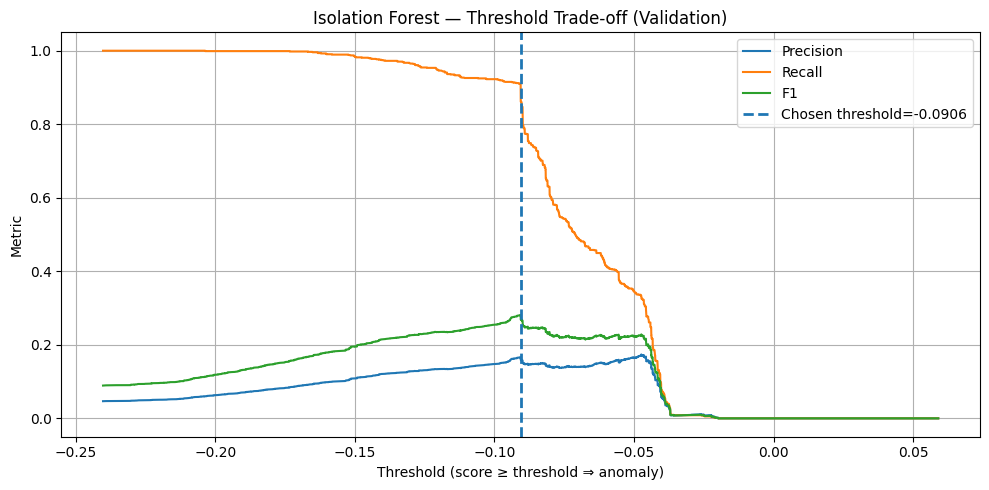

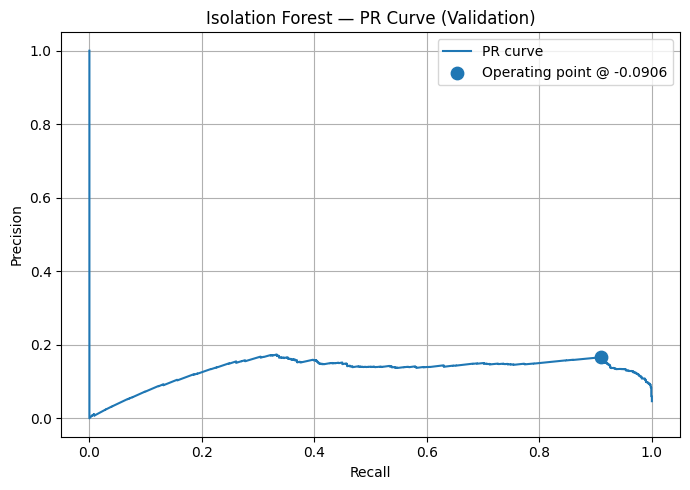

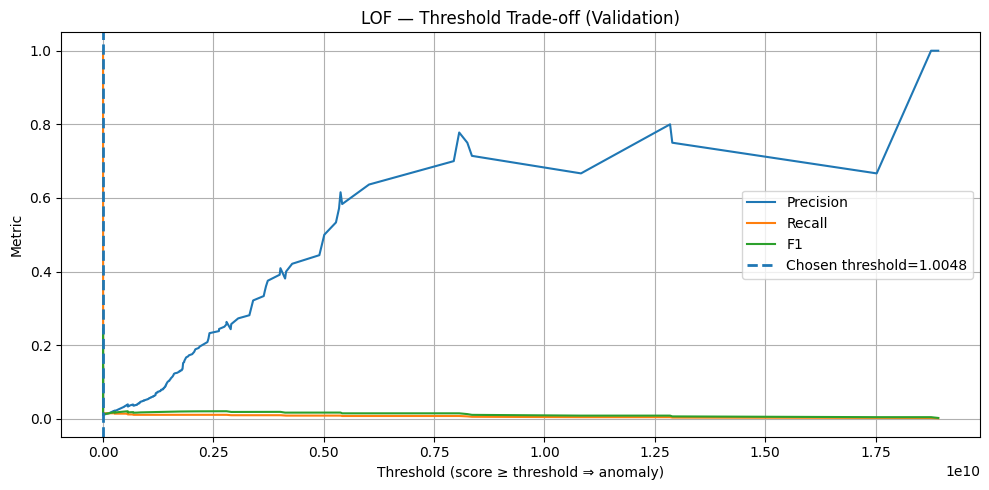

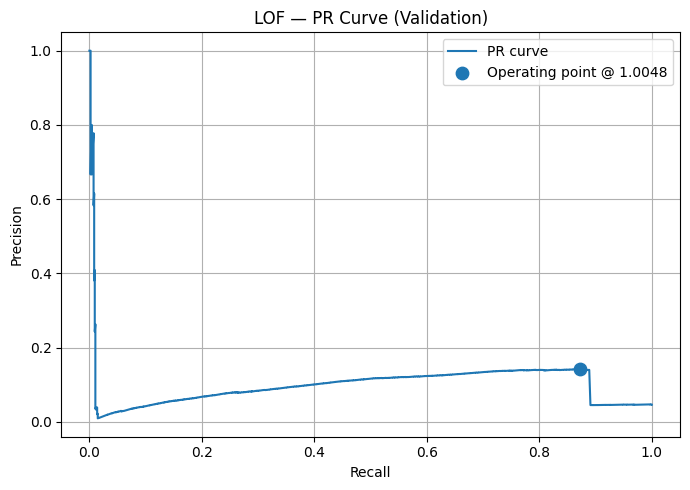

In [16]:
def threshold_tradeoff_plot(y_true, scores, chosen_threshold=None, title="Threshold trade-off"):
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    precision_t = precision[:-1]
    recall_t = recall[:-1]

    f1 = (2 * precision_t * recall_t) / (precision_t + recall_t + 1e-12)

    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, precision_t, label="Precision")
    plt.plot(thresholds, recall_t, label="Recall")
    plt.plot(thresholds, f1, label="F1")

    if chosen_threshold is not None:
        plt.axvline(chosen_threshold, linestyle="--", linewidth=2, label=f"Chosen threshold={chosen_threshold:.4f}")

    plt.xlabel("Threshold (score ≥ threshold ⇒ anomaly)")
    plt.ylabel("Metric")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def pr_curve_with_threshold_marker(y_true, scores, chosen_threshold=None, title="Precision–Recall Curve"):
    precision, recall, thresholds = precision_recall_curve(y_true, scores)

    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label="PR curve")

    if chosen_threshold is not None and len(thresholds) > 0:
        idx = np.argmin(np.abs(thresholds - chosen_threshold))
        plt.scatter([recall[idx]], [precision[idx]], s=80, label=f"Operating point @ {chosen_threshold:.4f}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# IF
threshold_tradeoff_plot(y_val, val_scores_if, best_thresh_if, "Isolation Forest — Threshold Trade-off (Validation)")
pr_curve_with_threshold_marker(y_val, val_scores_if, best_thresh_if, "Isolation Forest — PR Curve (Validation)")

# LOF
threshold_tradeoff_plot(y_val, val_scores_lof, best_thresh_lof, "LOF — Threshold Trade-off (Validation)")
pr_curve_with_threshold_marker(y_val, val_scores_lof, best_thresh_lof, "LOF — PR Curve (Validation)")

# AE (if present)
if KERAS_AVAILABLE and "val_mse" in globals():
    threshold_tradeoff_plot(y_val, val_mse, best_thresh_ae, "Autoencoder — Threshold Trade-off (Validation)")
    pr_curve_with_threshold_marker(y_val, val_mse, best_thresh_ae, "Autoencoder — PR Curve (Validation)")


Shows why threshold tuning is essential in unsupervised anomaly detection.

In [17]:
from sklearn.metrics import classification_report

labels_default = iso.predict(X_test_scaled)  # 1 normal, -1 anomaly
y_test_pred_default_if = (labels_default == -1).astype(int)

metrics_if_default = evaluate_model(y_test, y_test_pred_default_if, test_scores_if, "IF (default threshold)")
metrics_if_tuned = evaluate_model(y_test, y_test_pred_if, test_scores_if, "IF (tuned threshold)")

print("\n=== Ablation 1: Isolation Forest — Default vs Tuned (Test set) ===")
display(pd.DataFrame([metrics_if_default, metrics_if_tuned]))

print("\n[Default threshold] classification report:")
print(classification_report(y_test, y_test_pred_default_if, digits=4, zero_division=0))

print("\n[Tuned threshold] classification report:")
print(classification_report(y_test, y_test_pred_if, digits=4, zero_division=0))



=== Ablation 1: Isolation Forest — Default vs Tuned (Test set) ===


,model,accuracy,balanced_accuracy,precision,recall,f1,mcc,roc_auc,pr_auc
0,IF (default threshold),0.943745,0.494955,0.00000,0.000000,0.000000,-0.021798,0.853726,0.136623
1,IF (tuned threshold),0.784956,0.851291,0.16931,0.924448,0.286202,0.340048,0.853726,0.136623



[Default threshold] classification report:
              precision    recall  f1-score   support

           0     0.9529    0.9899    0.9711     24082
           1     0.0000    0.0000    0.0000      1178

    accuracy                         0.9437     25260
   macro avg     0.4765    0.4950    0.4855     25260
weighted avg     0.9085    0.9437    0.9258     25260


[Tuned threshold] classification report:
              precision    recall  f1-score   support

           0     0.9953    0.7781    0.8734     24082
           1     0.1693    0.9244    0.2862      1178

    accuracy                         0.7850     25260
   macro avg     0.5823    0.8513    0.5798     25260
weighted avg     0.9568    0.7850    0.8460     25260



Quantifies how feature engineering affects anomaly detection.

In [18]:
def build_basic_features(df_raw):
    df = df_raw.copy()
    drop_cols = [c for c in ["srcip", "dstip", "payload"] if c in df.columns]
    df = df.drop(columns=drop_cols, errors="ignore")

    for col in ["sport", "dsport", "sttl", "total_len", "stime"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

    df = pd.get_dummies(df, columns=["protocol_m"], drop_first=True)
    for c in df.columns:
        if c.startswith("protocol_m_"):
            df[c] = df[c].astype(int)

    numeric_cols = ["sport", "dsport", "sttl", "total_len", "stime"]
    protocol_cols = [c for c in df.columns if c.startswith("protocol_m_")]
    cols = numeric_cols + protocol_cols
    return df[cols], cols


def run_if_pipeline(X_features_df, y, cols, name_prefix=""):
    X_temp, X_test_l, y_temp, y_test_l = train_test_split(
        X_features_df, y,
        test_size=EXPERIMENT_CONFIG["test_size"],
        stratify=y,
        random_state=RANDOM_SEED
    )
    X_train_l, X_val_l, y_train_l, y_val_l = train_test_split(
        X_temp, y_temp,
        test_size=EXPERIMENT_CONFIG["val_size"],
        stratify=y_temp,
        random_state=RANDOM_SEED
    )

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_l[cols].values)
    X_val_s = scaler.transform(X_val_l[cols].values)
    X_test_s = scaler.transform(X_test_l[cols].values)

    X_train_b = X_train_s[y_train_l == 0]

    model = IsolationForest(contamination="auto", random_state=RANDOM_SEED, n_jobs=-1)
    model.fit(X_train_b)

    val_scores = -model.decision_function(X_val_s)
    test_scores = -model.decision_function(X_test_s)

    thr, f1v = tune_threshold_max_f1(y_val_l, val_scores)
    y_pred = (test_scores >= thr).astype(int)

    return evaluate_model(y_test_l, y_pred, test_scores, f"{name_prefix} IF (tuned)")


# Basic
X_basic, basic_cols = build_basic_features(df)
metrics_basic = run_if_pipeline(X_basic, df["binary_label"].values, basic_cols, name_prefix="Basic")

# Engineered (your final pipeline)
metrics_eng = run_if_pipeline(X_all_features, df["binary_label"].values, feature_cols, name_prefix="Engineered")

print("\n=== Ablation 2: Feature Engineering Impact (Isolation Forest) ===")
display(pd.DataFrame([metrics_basic, metrics_eng]))



=== Ablation 2: Feature Engineering Impact (Isolation Forest) ===


,model,accuracy,balanced_accuracy,precision,recall,f1,mcc,roc_auc,pr_auc
0,Basic IF (tuned),0.843191,0.759112,0.180335,0.666384,0.283855,0.289331,0.861071,0.137214
1,Engineered IF (tuned),0.784956,0.851291,0.169310,0.924448,0.286202,0.340048,0.853726,0.136623


Prints a short justification for your metric choices under class imbalance.

In [20]:
positive_rate = float(np.mean(y_test))

print("=== Metric Choice Justification (Test Set) ===")
print(f"Attack rate (positive class proportion): {positive_rate:.4f}")

print("\nWhy Accuracy is not enough:")
print("- With heavy class imbalance, predicting 'normal' most of the time can still produce high accuracy.")

print("\nWhy Precision/Recall/F1:")
print("- Precision measures false alarm burden (how many alerts are truly attacks).")
print("- Recall measures detection rate (how many attacks are detected).")
print("- F1 summarizes the trade-off at a chosen operating threshold.")

print("\nWhy ROC-AUC and PR-AUC:")
print("- ROC-AUC evaluates ranking quality independent of threshold.")
print("- PR-AUC is more informative than ROC-AUC under class imbalance (focus on the positive class).")
print(f"- Baseline PR-AUC for a random ranker ≈ attack rate ≈ {positive_rate:.4f}")

print("\nWhy Balanced Accuracy and MCC:")
print("- Balanced accuracy treats both classes equally (mean of TPR and TNR).")
print("- MCC remains informative under imbalance and penalizes both FP and FN.")


=== Metric Choice Justification (Test Set) ===
Attack rate (positive class proportion): 0.0466

Why Accuracy is not enough:
- With heavy class imbalance, predicting 'normal' most of the time can still produce high accuracy.

Why Precision/Recall/F1:
- Precision measures false alarm burden (how many alerts are truly attacks).
- Recall measures detection rate (how many attacks are detected).
- F1 summarizes the trade-off at a chosen operating threshold.

Why ROC-AUC and PR-AUC:
- ROC-AUC evaluates ranking quality independent of threshold.
- PR-AUC is more informative than ROC-AUC under class imbalance (focus on the positive class).
- Baseline PR-AUC for a random ranker ≈ attack rate ≈ 0.0466

Why Balanced Accuracy and MCC:
- Balanced accuracy treats both classes equally (mean of TPR and TNR).
- MCC remains informative under imbalance and penalizes both FP and FN.
